### Haplotype Structure of Tyk2

This notebook reads in variant information, including frequencies, and linkage diseqiuilibrium matrices for the genomic interval containing TYK2. There are two functions `read_ld_gnomad` and `read_ld_ukb` to read these files and compute `d` and `dprime` based on the reported `r` values from Hail. The important outputs are simply two plots, faceted by population group, which show `dprime` for each variant in each population with respect to `P1104A`. In all plots, `P1104A` and `V362F`.

#### Gnomad v2.1.1

In [53]:
library(fs)
library(magrittr)
library(vroom)
#library(ggpubr)
library(scico)
library(scales)
library(tidyverse)

In [52]:
read_ld_gnomad <- function(var_path, var_id){
    
    ld_path <- gsub("-vars.txt","-mat.tsv", var_path)
    ld <- vroom(ld_path, col_names = FALSE)
    variants <- read_tsv(var_path, col_types = "nccnnnnn")
        
    i <- which(variants$locus == var_id)
    p1104a_freq <- variants$pop_freq.AF[[i]]
    
    ld_row <- c(unlist(ld[1:i,i]), unlist(ld[i,(i+1):ncol(ld)]))
    variants$ld <- ld_row^2
    variants$d <- variants$ld*p1104a_freq*(1-p1104a_freq)*variants$pop_freq.AF*(1-variants$pop_freq.AF)

    variants$dmax <- NA
    idx_neg <- which(ld_row < 0)
    idx_pos <- which(ld_row > 0)
    
    variants$dmax[idx_neg] <- pmin(-p1104a_freq*(1-variants$pop_freq.AF[idx_neg]),
                                   -variants$pop_freq.AF[idx_neg]*(1-p1104a_freq))
    variants$dmax[idx_pos] <- pmin(p1104a_freq*(1-variants$pop_freq.AF[idx_pos]),
                                   variants$pop_freq.AF[idx_pos]*(1-p1104a_freq))

    variants$dprime <- sqrt(variants$d) / variants$dmax
    
    variants <- variants %>%
        separate(locus, c("chr","pos"), ":") %>%
        mutate(pos = as.numeric(pos))
    
    return(variants)
}

In [12]:
files <- dir_ls("../data/tyk2/ld/", glob = "*unadj*vars.txt")
names(files) <- gsub("../data/tyk2/ld/tyk2-unadj-|-vars.txt","",files,perl=T)
alldata <- files[-4] %>% map_dfr(read_ld_gnomad, .id = "popgroup", var_id = "19:10463118")

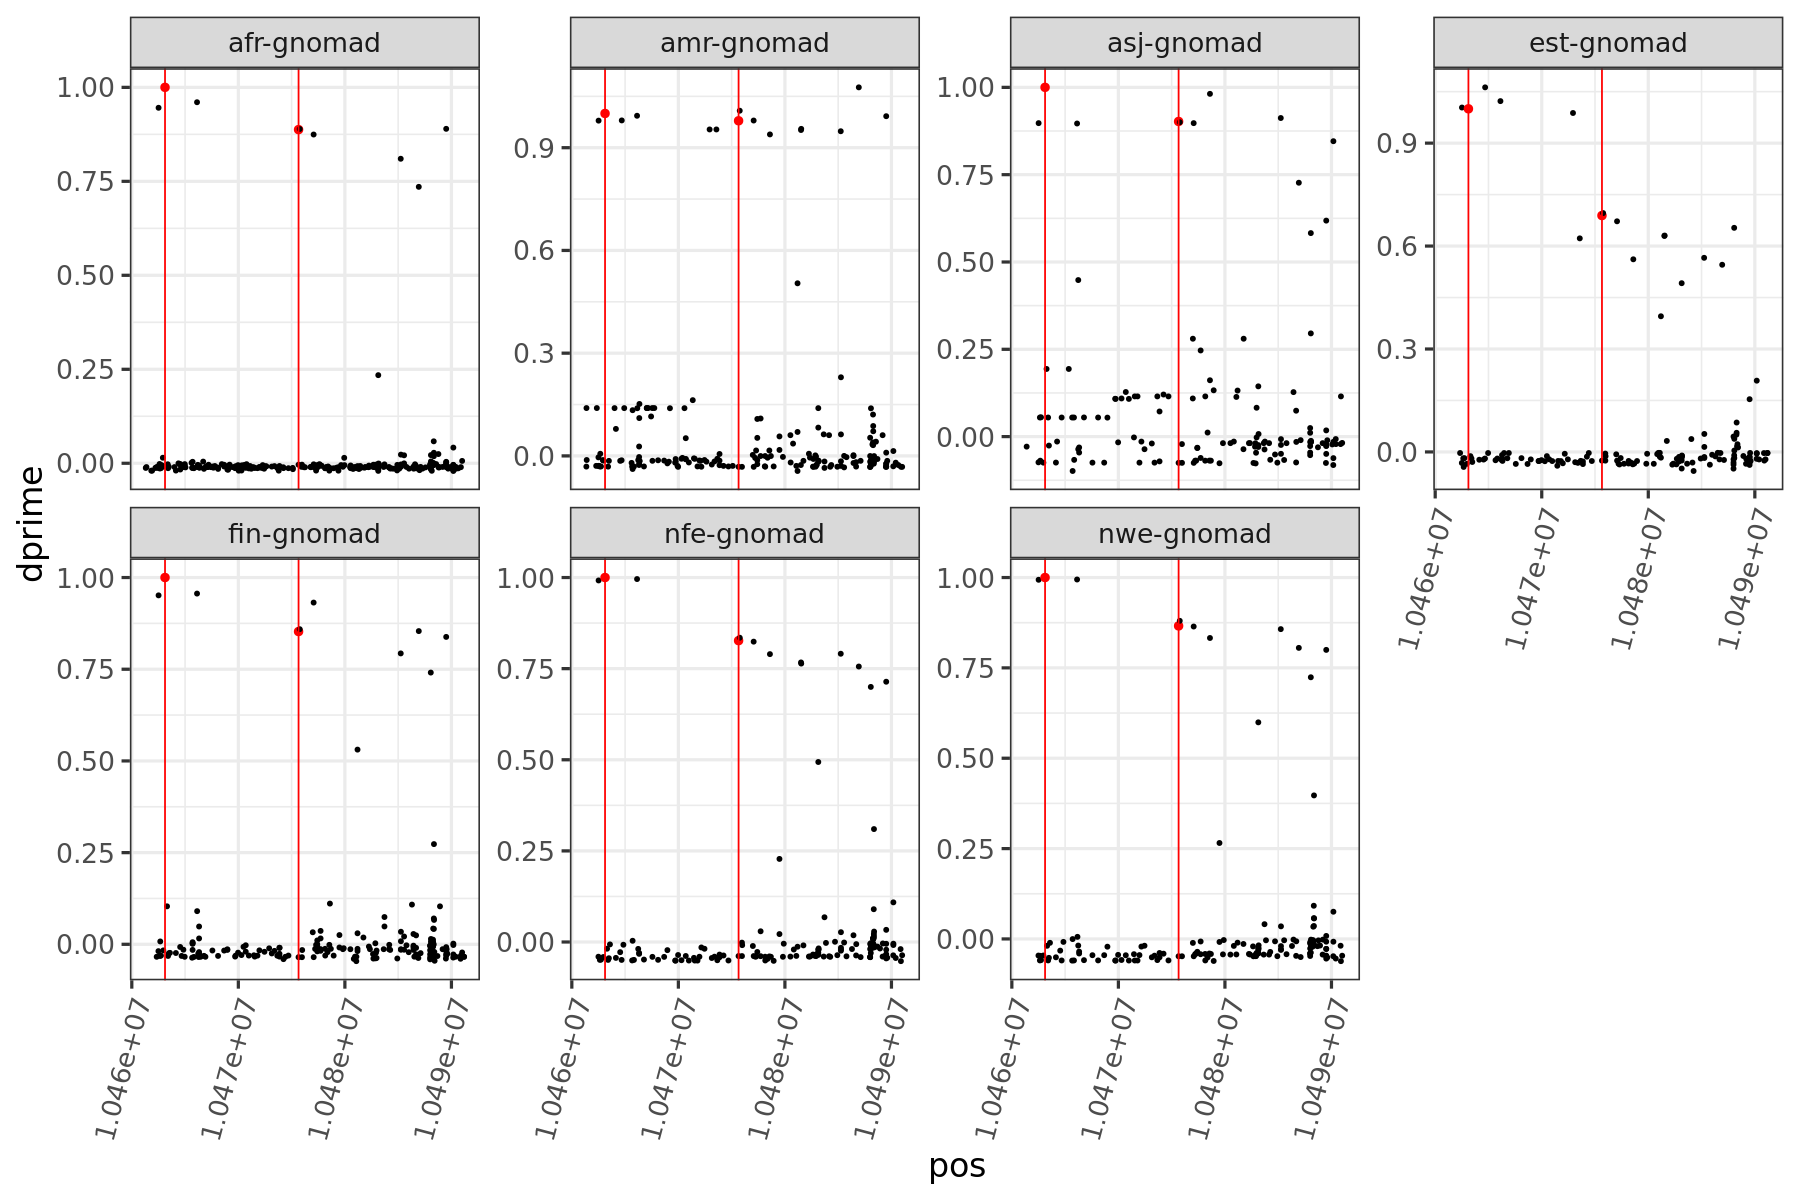

In [51]:
options(repr.plot.width = 15, repr.plot.height = 10)
ggplot(alldata %>% filter(pop_freq.AF <= 0.5 & popgroup != "seu-gnomad")) +
    geom_point(aes(x = pos, y = dprime,
                   color = if_else(pos %in% c(10463118,10475652), "red","black"),
                   size = if_else(pos %in% c(10463118,10475652), 2,1))) +
    geom_vline(xintercept = c(10463118,10475652), color = "red") + 
    theme_bw(base_size = 20) +
    theme(legend.position = "none", axis.text.x = element_text(angle = 75, vjust=1, hjust = 1)) +
    scale_size_identity() +
    scale_color_identity() +
    scale_x_continuous(labels = function(x) format(x, scientific = TRUE)) +
    facet_wrap(~popgroup, scales = "free_y", nrow = 2) 

#### Pan-UK Biobank

In [71]:
read_ld_ukb <- function(var_path, var_id){
    
    ld_path <- gsub("-vars.txt","-mat.tsv", var_path)
    ld <- vroom(ld_path, col_names = FALSE)
    variants <- read_tsv(var_path, col_types = "ncccnn")
        
    i <- which(variants$locus == var_id)
    p1104a_freq <- variants$AF[[i]]
    
    ld_row <- c(unlist(ld[1:i,i]), unlist(ld[i,(i+1):ncol(ld)]))
    variants$ld <- ld_row^2
    variants$d <- variants$ld*p1104a_freq*(1-p1104a_freq)*variants$AF*(1-variants$AF)

    variants$dmax <- NA
    idx_neg <- which(ld_row < 0)
    idx_pos <- which(ld_row > 0)
    
    variants$dmax[idx_neg] <- pmin(-p1104a_freq*(1-variants$AF[idx_neg]),
                                   -variants$AF[idx_neg]*(1-p1104a_freq))
    variants$dmax[idx_pos] <- pmin(p1104a_freq*(1-variants$AF[idx_pos]),
                                   variants$AF[idx_pos]*(1-p1104a_freq))

    variants$dprime <- sqrt(variants$d) / variants$dmax
    
    variants <- variants %>%
        separate(locus, c("chr","pos"), ":") %>%
        mutate(pos = as.numeric(pos))
    
    return(variants)
}

In [77]:
files <- dir_ls("../data/tyk2/ld/", glob = "*panukbb*vars.txt")
names(files) <- gsub("../data/tyk2/ld/tyk2-ld-|-vars.txt","",files,perl=T)
alldata_ukb <- files %>% map_dfr(read_ld_ukb, .id = "popgroup", var_id = "19:10463118")

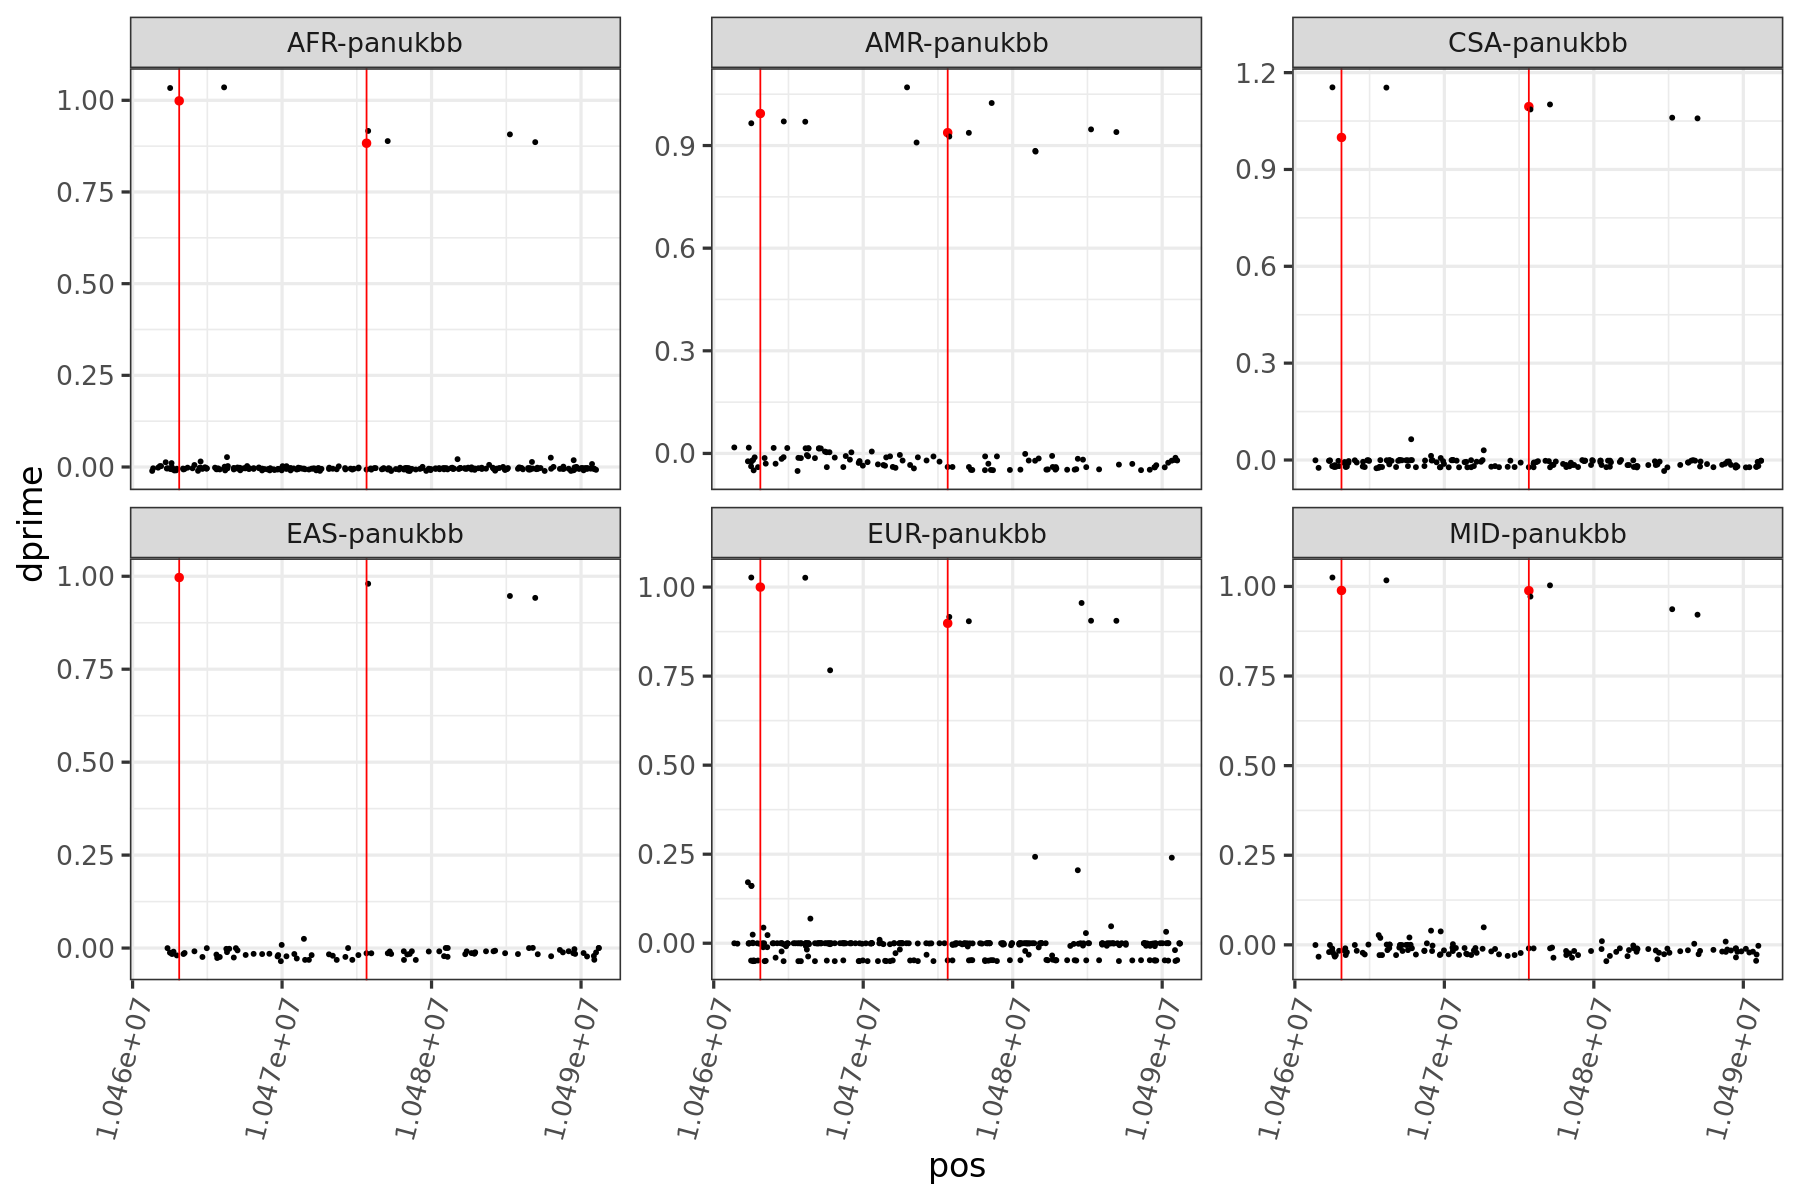

In [79]:
options(repr.plot.width = 15, repr.plot.height = 10)
ggplot(alldata_ukb %>% filter(AF <= 0.5)) +
    geom_point(aes(x = pos, y = dprime,
                   color = if_else(pos %in% c(10463118,10475652), "red","black"),
                   size = if_else(pos %in% c(10463118,10475652), 2,1))) +
    geom_vline(xintercept = c(10463118,10475652), color = "red") + 
    theme_bw(base_size = 20) +
    theme(legend.position = "none", axis.text.x = element_text(angle = 75, vjust=1, hjust = 1)) +
    scale_size_identity() +
    scale_color_identity() +
    scale_x_continuous(labels = function(x) format(x, scientific = TRUE)) +
    facet_wrap(~popgroup, scales = "free_y", nrow = 2) 